### IMDB recommendation system


In [1]:
%%capture
!pip install pandas-profiling; #to get the overview of data
!pip install wordcloud
!pip install squarify
!pip install pywaffle

In [2]:
import sys
!{sys.executable} -m pip install pandas-profiling

In [3]:
from collections import defaultdict, Counter
from functools import partial
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
from pandas_profiling import ProfileReport
from pywaffle import Waffle
import squarify
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from wordcloud import WordCloud

pd.set_option("display.max_columns", None)
%matplotlib inline

In [4]:
credit = pd.read_csv("tmdb_5000_credits.csv")
movie = pd.read_csv('tmdb_5000_movies.csv')

In [5]:
credit.head(1)

movie_id   title                                               cast  \
0     19995  Avatar  [{"cast_id": 242, "character": "Jake Sully", "...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...

In [6]:
# join the datasets on ID column
credit.columns = ['id','tittle','cast','crew']
movie_df = movie.merge(credit, on='id')
del movie
del credit

In [7]:
movie_df.head(1)

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                      homepage     id  \
0  http://www.avatarmovie.com/  19995   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   

  original_title                                           overview  \
0         Avatar  In the 22nd century, a paraplegic Marine is di...   

   popularity                               production_companies  \
0  150.437577  [{"name": "Ingenious Film Partners", "id": 289...   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   

                       tagline   title  vote_average  vote_count  tittle  \
0  Enter the World of Pandora.  Avatar           7.2       11800  Avatar   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...

In [8]:
# # the fastest way to get familiarize dataset and see much information - one line code to get you all details about the dataset
Overview = ProfileReport(movie_df)
Overview

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
## basic data cleaning

In [10]:
# convert date appropriate format
movie_df["release_date"] = pd.to_datetime(movie_df['release_date'])
movie_df['release_year'] = movie_df['release_date'].dt.year
movie_df['release_month'] = movie_df['release_date'].dt.month_name()
del movie_df["release_date"]

In [11]:
# transform all columns which had json string into json format
# several columns has id and name
# leave only name for them beacause id is not so important in this case
json_columns = {'cast', 'crew', 'genres', 'keywords', 'production_countries', 
                'production_companies', 'spoken_languages'}

for c in json_columns:
    movie_df[c] = movie_df[c].apply(json.loads)
    if c != "crew": # We need other information besides the name
        movie_df[c] = movie_df[c].apply(lambda row: [x["name"] for x in row])

In [12]:
# create director writer and producer columns 
def get_job(job, row):
    person_name = [x['name'] for x in row if x['job']==job] 
    return person_name[0] if len(person_name) else np.nan

movie_df["director"] = movie_df["crew"].apply(partial(get_job, "Director"))
movie_df["writer"]   = movie_df["crew"].apply(partial(get_job, "Writer"))
movie_df["producer"] = movie_df["crew"].apply(partial(get_job, "Producer"))
del movie_df["crew"]

# create profit column
movie_df["profit"] = movie_df["revenue"] - movie_df["budget"]

In [13]:
# fill some missing values by most frequent one
for col in ["runtime", "release_year", "release_month"]:
    movie_df[col] = movie_df[col].fillna(movie_df[col].mode().iloc[0])


movie_df.head(2)

In [14]:
## Data visualization - Also called Exploratory data analysis 
## Financials

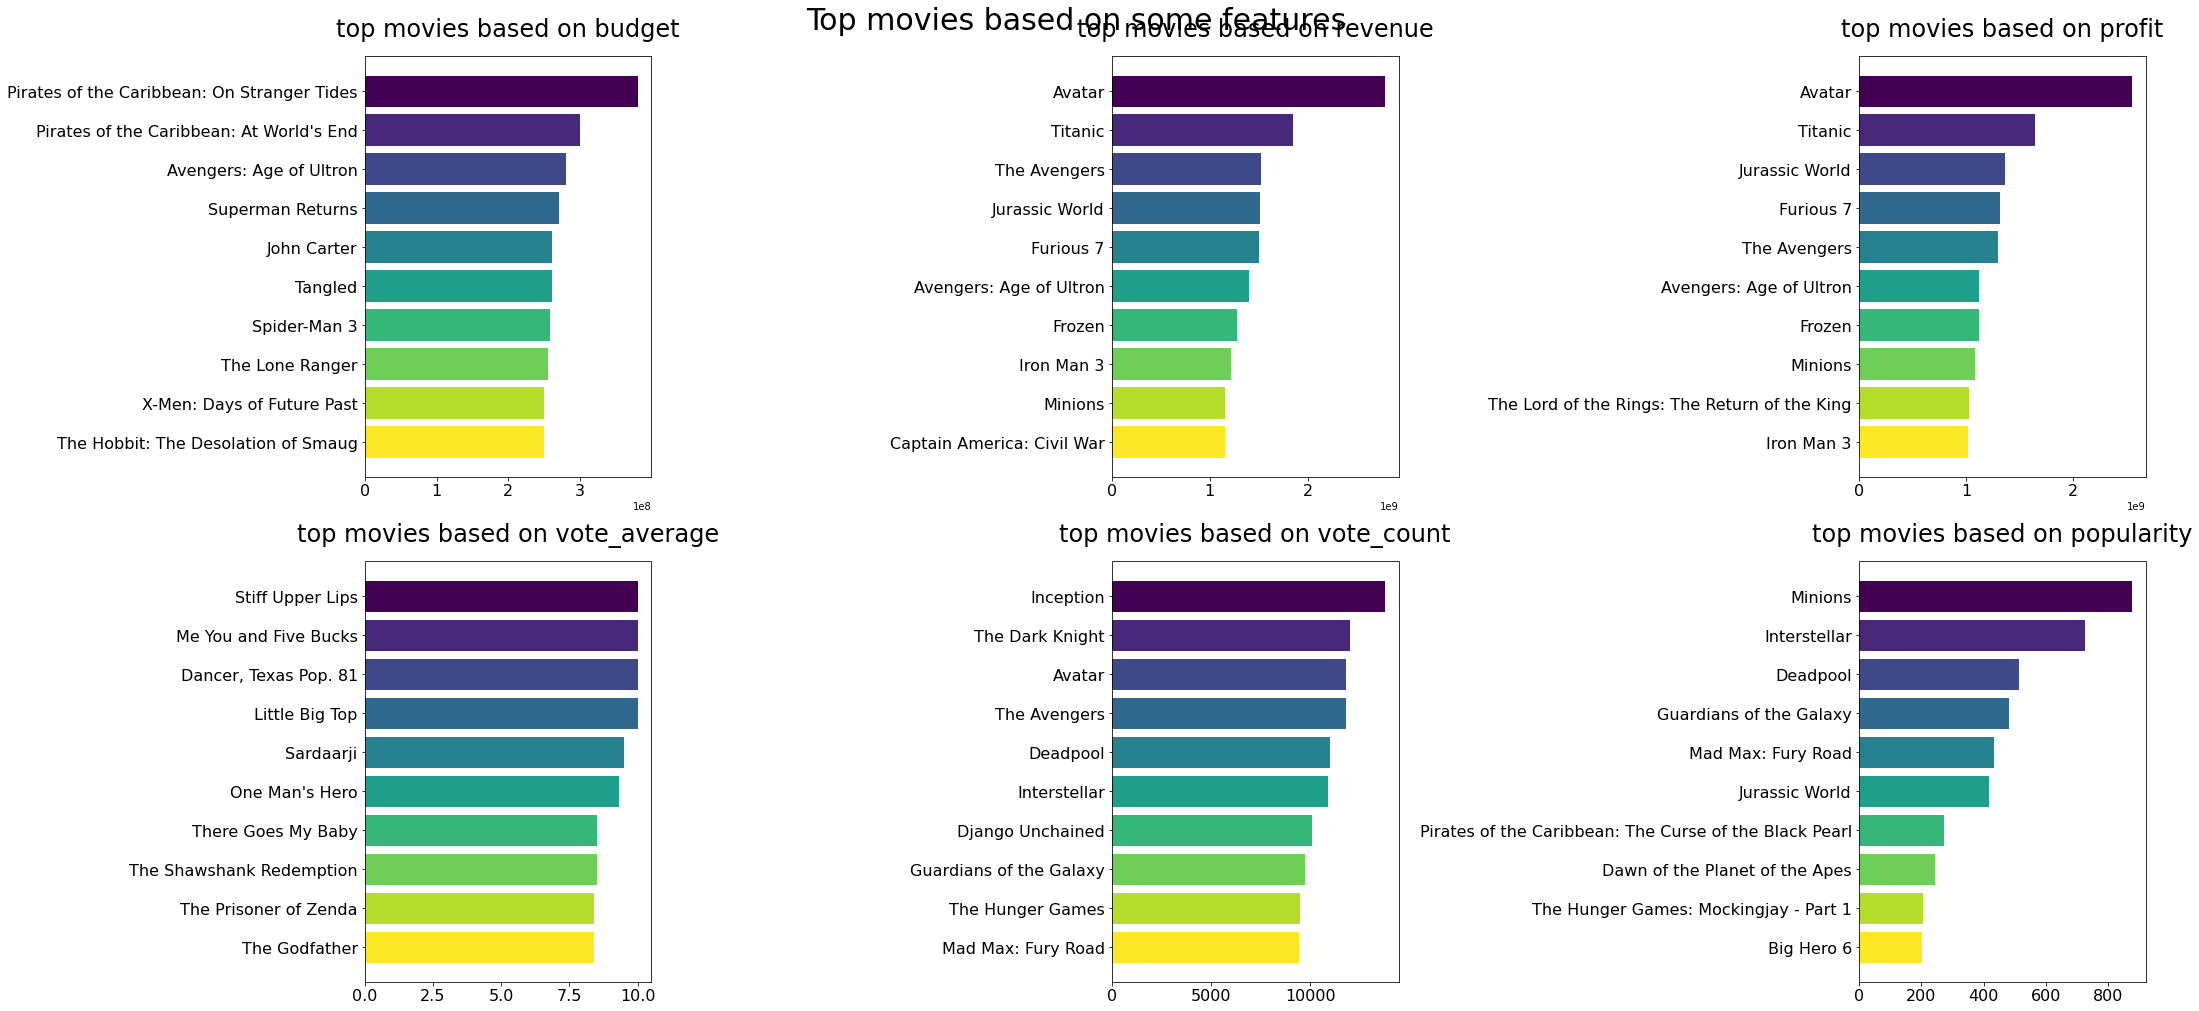

In [15]:
top_movie_num = 10
top_movies_based_on = ["budget", "revenue", "profit", "vote_average", "vote_count", "popularity"]

fig, ax = plt.subplots(len(top_movies_based_on)//3, 3, figsize=(30,14))
colors = plt.cm.get_cmap('viridis', top_movie_num)

for i, col in enumerate(top_movies_based_on):
    top_movies_by = movie_df.sort_values(by=[col], ascending=False).head(top_movie_num)
    r, c = i//3, i%3
    ax[r][c].barh(top_movies_by["title"], top_movies_by[col], color=colors.colors)
    ax[r][c].set_title(f"top movies based on {col}", fontsize=24, pad=20)
    ax[r][c].tick_params(axis='both', which='major', labelsize=16)
    ax[r][c].invert_yaxis()    
    
plt.suptitle('Top movies based on some features',fontsize=30, y=1)
fig.tight_layout()

In [16]:
### Generes

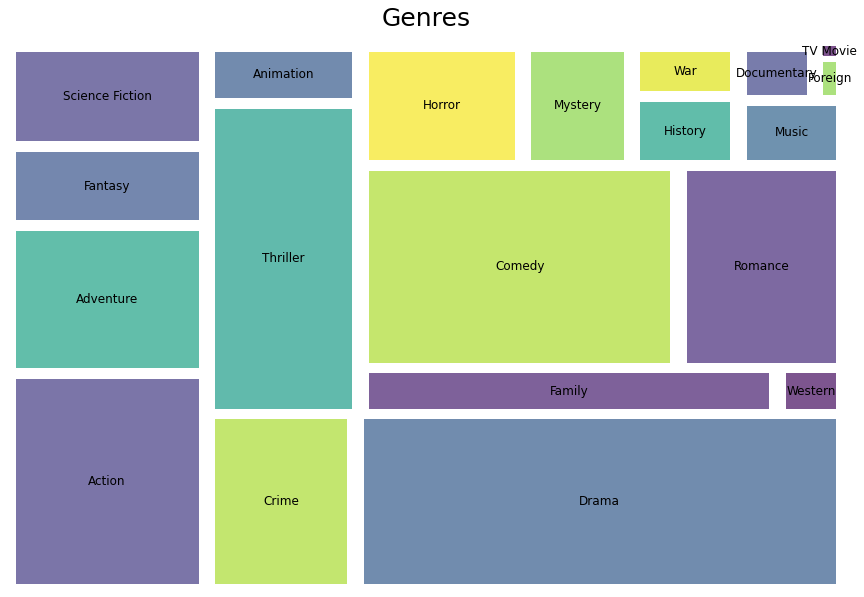

In [17]:
# plot genre frequncy with treemap 
genres_flatten = sum(movie_df["genres"].values, []) # genres are list of lists
genres_info = Counter(genres_flatten)

plt.figure(figsize=(15, 10))
plt.title("Genres", fontsize=25, pad=20)
squarify.plot(genres_info.values(), label=genres_info.keys(), text_kwargs={'fontsize':12}, bar_kwargs={'alpha':.7}, pad=True)
plt.axis("off");

In [18]:
### keywords

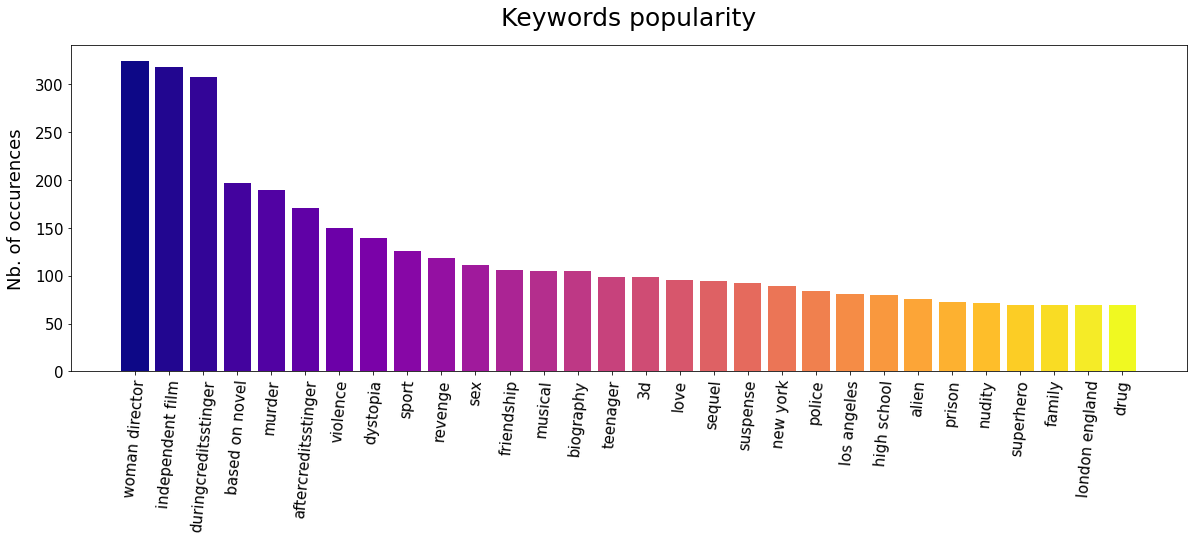

In [19]:
top_keywords_num = 30
keywords_flatten = sum(movie_df["keywords"].values, []) # keywords are list of lists
keywords_info = Counter(keywords_flatten)
top_keywords = dict(keywords_info.most_common(top_keywords_num))

plt.figure(figsize=(20, 6))
plt.xticks(rotation=85, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Nb. of occurences", fontsize=18, labelpad=10)
plt.bar(top_keywords.keys(), top_keywords.values(), align='center', color=plt.cm.get_cmap('plasma', top_keywords_num).colors)
plt.title("Keywords popularity", fontsize=25, pad=20)
plt.show()

In [20]:
### production_countries

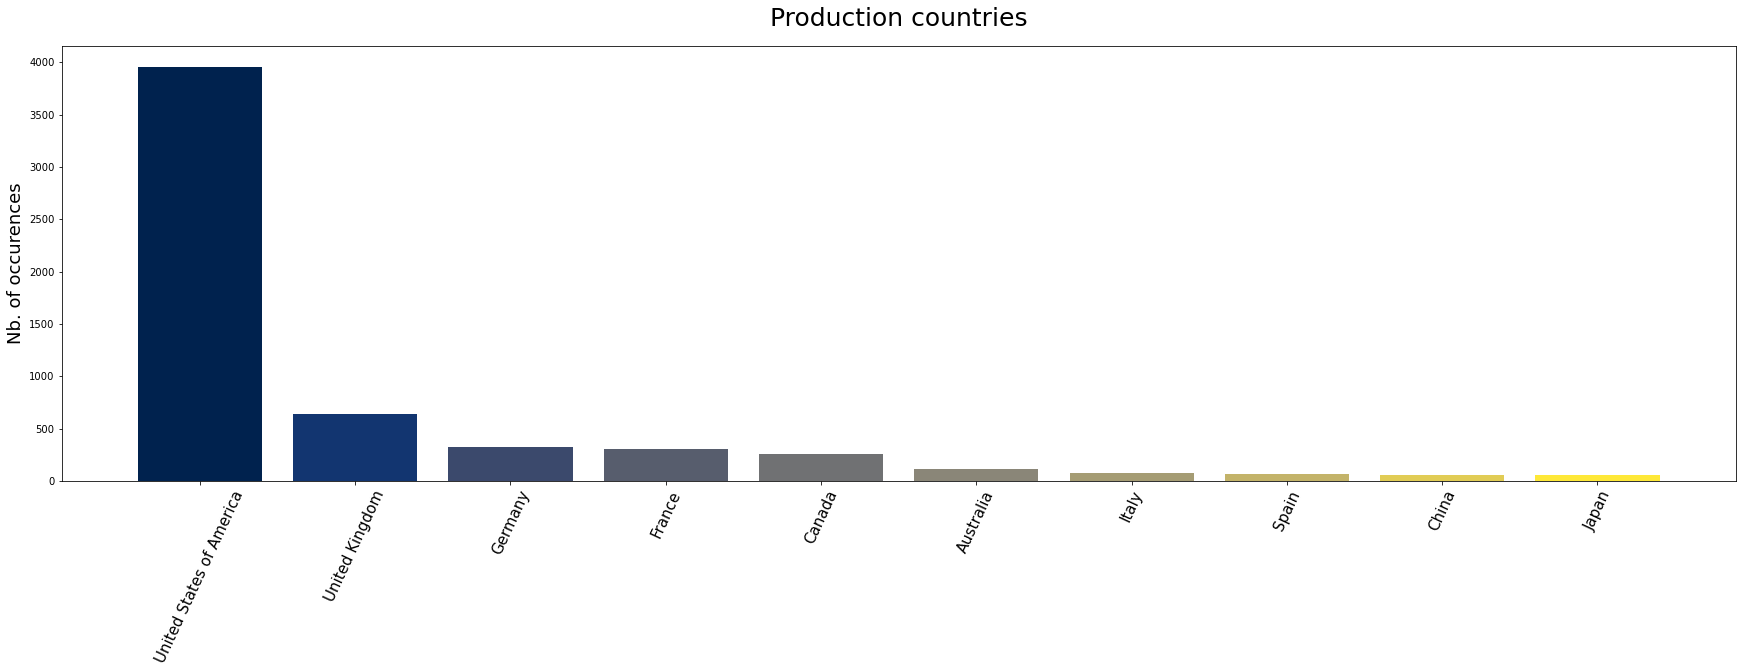

In [21]:
top_contries_num = 10
production_contries_flatten = sum(movie_df["production_countries"].values, []) # production_countries are list of lists
production_contries_info = Counter(production_contries_flatten)
top_production_contries = production_contries_info.most_common(top_contries_num)

plt.figure(figsize=(30, 8))
plt.xticks(rotation=65, fontsize=15)
plt.ylabel("Nb. of occurences", fontsize=18)
plt.title("Production countries", fontsize=25, pad=20)
plt.bar(dict(top_production_contries).keys(), dict(top_production_contries).values(), color=plt.cm.get_cmap('cividis', top_contries_num).colors);

In [22]:
### cast 

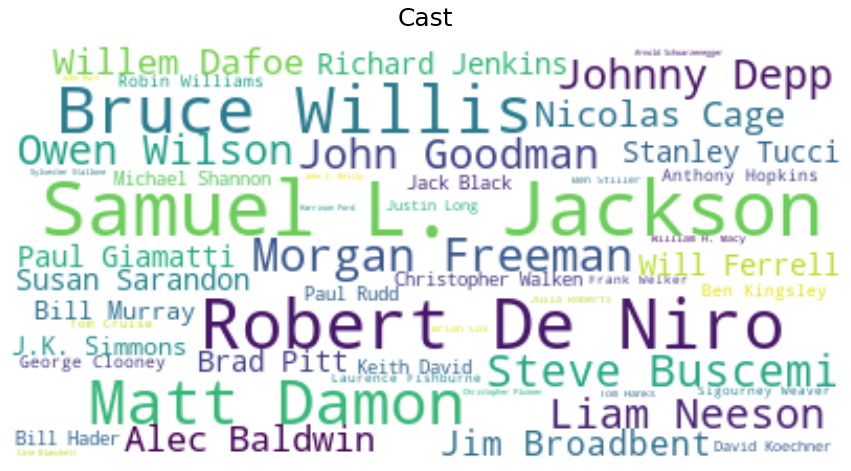

In [23]:
# plot unique cast frequency
cast_flatten = sum(movie_df["cast"].values, []) # cast are list of lists
cast_info = Counter(cast_flatten)

wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(dict(cast_info.most_common(50)))

plt.figure(figsize=(15,10))
plt.title("Cast", fontsize=25, pad=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

In [24]:
### correlation

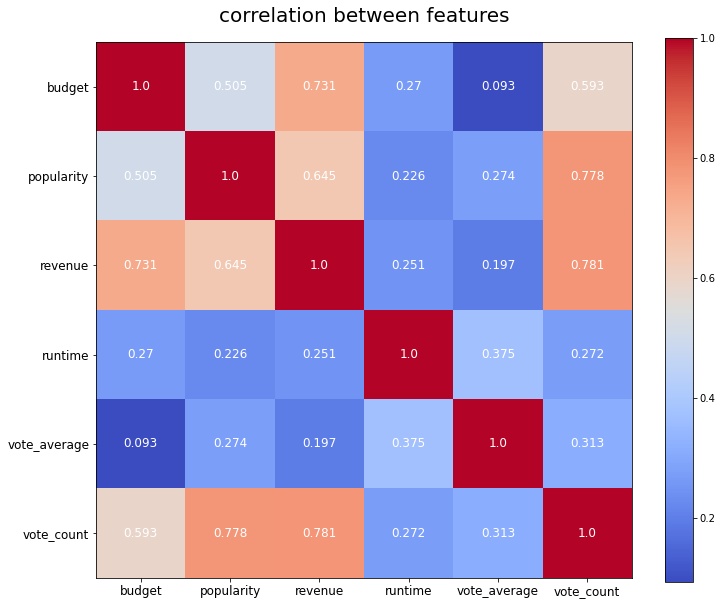

In [25]:
matrix = movie_df[["budget", "popularity", "revenue", "runtime", "vote_average", "vote_count"]].corr()

f, ax = plt.subplots(figsize=(12, 10))
plt.title("correlation between features", fontsize=20, pad=20)
plt.xticks(range(len(matrix.index)), matrix.index, fontsize=12)
plt.yticks(range(len(matrix.index)), matrix.index, fontsize=12)

# adding values
for i in range(len(matrix.index)):
    for j in range(len(matrix.index)):
        text = ax.text(j, i, round(matrix.iloc[i, j],3), ha="center", va="center", color="w", fontsize=12)
        
plt.imshow(matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar();

In [26]:
### builing Recommender System using weighted rating

In [27]:
C = movie_df['vote_average'].mean()
m = movie_df['vote_count'].quantile(0.9)
q_movies = movie_df.copy().loc[movie_df['vote_count'] >= m]
C, m, q_movies.shape

(6.092171559442011, 1838.4000000000015, (481, 27))

In [28]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
q_movies = q_movies.sort_values('score', ascending=False)
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(5)

title  vote_count  vote_average     score
1881  The Shawshank Redemption        8205           8.5  8.059258
662                 Fight Club        9413           8.3  7.939256
65             The Dark Knight       12002           8.2  7.920020
3232              Pulp Fiction        8428           8.3  7.904645
96                   Inception       13752           8.1  7.863239

In [29]:
movie_df['overview'].head(3)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
Name: overview, dtype: object

In [30]:
movie_df['overview'] = movie_df['overview'].fillna('')

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_df['overview'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movie_df.index, index=movie_df['title']).drop_duplicates()

tfidf_matrix.shape

(4803, 20978)

In [31]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    movie_similarity = [i[1] for i in sim_scores]

    return pd.DataFrame(zip(movie_df['title'].iloc[movie_indices], movie_similarity), columns=["title", "similarity"])

In [32]:
get_recommendations('The Godfather: Part II')

title  similarity
0             The Godfather    0.412329
1   The Godfather: Part III    0.259649
2  An American in Hollywood    0.121267
3       A Most Violent Year    0.111731
4                    Casino    0.110821

In [33]:
get_recommendations('The Avengers')

title  similarity
0  Avengers: Age of Ultron    0.146374
1                  Plastic    0.122791
2                  Timecop    0.110385
3       This Thing of Ours    0.107529
4    Thank You for Smoking    0.106203

In [34]:
get_recommendations('Broken City')

title  similarity
0             Young Guns    0.163406
1  Beverly Hills Cop III    0.152574
2                Shooter    0.121269
3              City Hall    0.116769
4           Dante's Peak    0.114179

In [35]:
### Content based with more features

In [36]:
# leave only top values for some features
# for example we dont need to take all casts
features = ['cast', 'keywords', 'genres']
top_num = 5
for feature in features:
    movie_df[feature] = movie_df[feature].apply(lambda x: x[:top_num] if isinstance(x, list) else [])

In [37]:
# remove spaces for some features
# because we don't need "Johnny Depp" and "Johnny Galecki" as the same
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(" ", ""))
    else:
        return ''
    
features = ['cast', 'keywords', 'genres', 'director', "writer", "producer", "production_companies", "production_countries"]

for feature in features:
    movie_df[feature] = movie_df[feature].apply(clean_data)

In [38]:
def create_joined_features(x):
    return ' '.join([' '.join(x[f]) if isinstance(x[f], list) else str(x[f]) for f in features])

movie_df["join_features"] = movie_df.apply(create_joined_features, axis=1)

In [39]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movie_df['join_features'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
movie_df = movie_df.reset_index()
indices = pd.Series(movie_df.index, index=movie_df['title'])

count_matrix.shape

(4803, 24176)

In [40]:
get_recommendations('The Godfather: Part II', cosine_sim2)

title  similarity
0  The Godfather: Part III    0.559503
1         The Conversation    0.487950
2            The Godfather    0.410391
3           Apocalypse Now    0.350000
4            The Rainmaker    0.316228

In [41]:
get_recommendations('The Avengers', cosine_sim2)

title  similarity
0              Avengers: Age of Ultron    0.804030
1                           Iron Man 2    0.628828
2  Captain America: The Winter Soldier    0.611111
3           Captain America: Civil War    0.540621
4                 Thor: The Dark World    0.514496

In [42]:
get_recommendations('Pulp Fiction', cosine_sim2)

title  similarity
0  Kill Bill: Vol. 2    0.410391
1  Kill Bill: Vol. 1    0.391293
2       Jackie Brown    0.378517
3              Basic    0.300376
4     Reservoir Dogs    0.300376

In [43]:
get_recommendations('Lone Survivor', cosine_sim2)

title  similarity
0   Battleship    0.299392
1   Contraband    0.297044
2        U-571    0.268438
3  The Kingdom    0.255945
4  Broken City    0.254772